In [1]:
import torch
import os
import json
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import cycle

In [83]:
def means_stds_ranks(layers, model_name, keys=None):

    means = defaultdict(list)
    stds = defaultdict(list)


    for layer in layers:
        filename =f'../../cruft/50_{model_name}_blocks.{layer}.hook_resid_pre_cos.json' 
        if os.path.exists(filename):
            with open(filename) as f:
                corrs = json.load(f)


            corrs = {key: corrs[key] for key in keys if key in corrs}

            for k, token_dict in corrs.items():
                if keys is None or k in keys:
                    s = torch.stack([torch.tensor(t) for t in token_dict]).mean(dim=0)
                    means[k].append(s.mean().item())
                    stds[k].append(s.std().item())


    print('means', means.keys())

    ranks = {k: [0] * len(layers) for k in means}
    for layer in range(len(layers)):
        layer_means = {k: means[k][layer] for k in means}
        sorted_keys = sorted(layer_means, key=layer_means.get, reverse=True)
        r = {key: rank for rank, key in enumerate(sorted_keys, 1)}

        for k in r:
            ranks[k][layer] = r[k]

    return means, ranks, stds

In [36]:
layers = list(range(40, -1, -3))
layers.reverse()
params = {
    'gemma-2-9b': (layers),
    'gemma-2b': (list(range(17))),
    'gpt2-small': (list(range(11))),
}

In [100]:
data= {}
for i, (model_name, layers) in enumerate(params.items()):

    # means, ranks, stds = means_stds_ranks(layers, model_name, keys=['[t]', "[<bos>, t]", "[t, t]", '[37233, t]', '[" ", t]', '[<bos>, 37233]', '[<pad>, <bos>, t]', '[<bos>, <pad>, t]',])

    means, ranks, stds = means_stds_ranks(layers, model_name, keys=['[t]', "[<bos>, t]", '[<pad>, <bos>, t]', '[<bos>, <pad>, t]',])

    data[model_name] = (layers, means, ranks, stds)


means dict_keys(['[t]', '[<bos>, t]', '[<pad>, <bos>, t]', '[<bos>, <pad>, t]'])
means dict_keys(['[t]', '[<bos>, t]', '[<pad>, <bos>, t]', '[<bos>, <pad>, t]'])
means dict_keys(['[t]', '[<bos>, t]'])


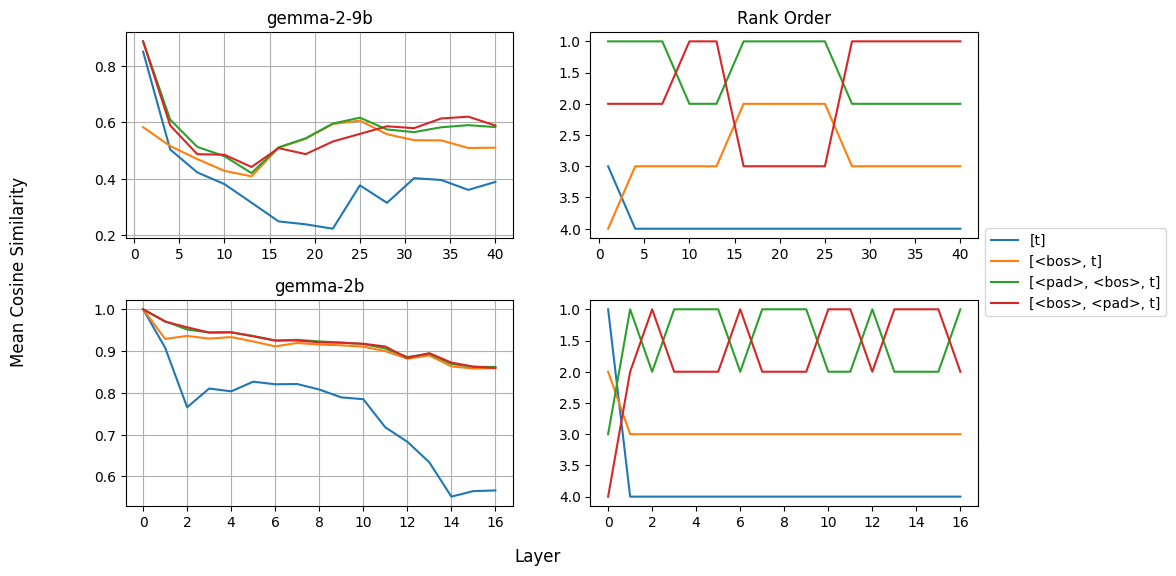

In [105]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(2, 2, figsize=(11, 6))

for i, (model_name, (layers, means, ranks, stds)) in enumerate(data.items()):
    if i == 2:
        continue
    for k in means.keys():
        if i == 0:
            label = k
        else:
            label = None
        ax[i][0].plot(layers, means[k], label=label)

    for k in ranks.keys():
        ax[i][1].plot(layers, ranks[k])

    ax[i][0].grid()
    ax[i][0].set_title(model_name)  # Title for model name on each graph in the first column

    if i == 0:  # Set axis titles only for the top row for clarity
        ax[i][1].set_title('Rank Order')  # Title for the vertical axis on graphs in the second column
    ax[i][1].invert_yaxis()
# Set overall labels and adjust subplot
f.supxlabel('Layer')  # Overall X-axis label
f.supylabel('Mean Cosine Similarity')  # Overall Y-axis label
f.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
plt.subplots_adjust(hspace=0.3, top=0.9)
plt.show()



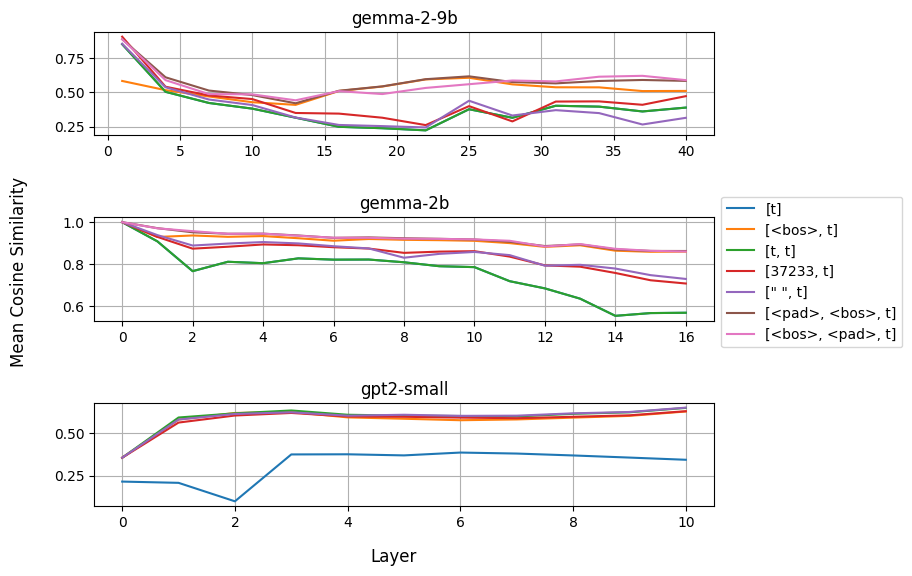

In [85]:
f, ax = plt.subplots(len(params), 1, figsize=(8, 6))

for i, (model_name, (layers, means, ranks, stds)) in enumerate(data.items()):
    for k in means.keys():
        if k == '[<bos>, 37233]':
            continue
        if i == 0:
            label = k
        else:
            label = None
        ax[i].plot(layers, means[k], label=label)

    ax[i].grid()
    ax[i].set_title(model_name)

plt.subplots_adjust(hspace=0.8, top=0.9)
f.supxlabel('Layer')  # Overall X-axis label
f.supylabel('Mean Cosine Similarity')  # Overall Y-axis label
f.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))


In [68]:
import numpy as np

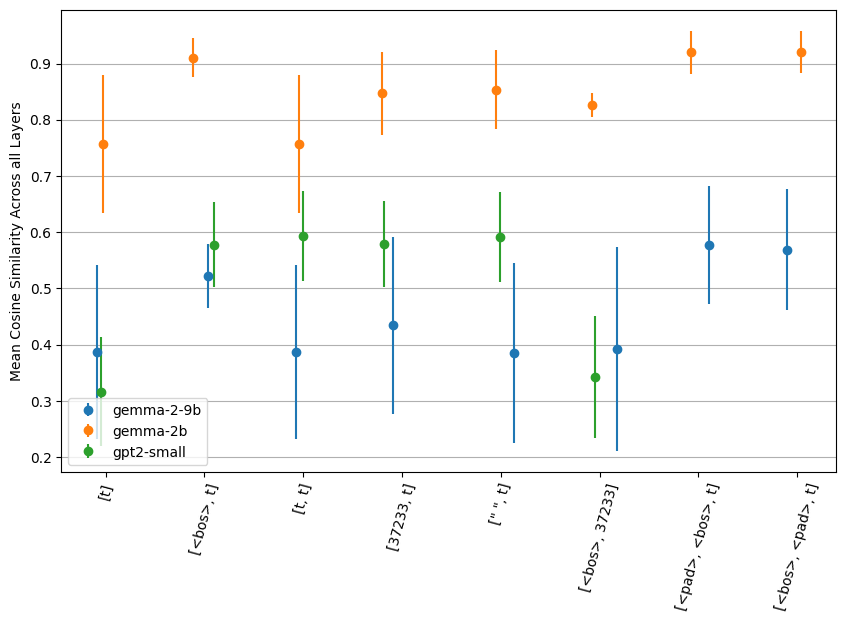

In [88]:
plt.figure(figsize=(10, 6))

labs = None
for i, (model_name, (layers, means, ranks, stds)) in enumerate(data.items()):
    # Compute mean and standard deviation
    mean_means = {k: torch.tensor(v).mean() for k, v in means.items()}
    mean_stds = {k: torch.tensor(v).std() for k, v in means.items()}

    # Generate x values with jitter to reduce overlap
    x_values = np.arange(len(mean_means)) + np.random.normal(scale=0.1, size=len(mean_means))

    # Plotting with error bars
    plt.errorbar(x_values, list(mean_means.values()), yerr=list(mean_stds.values()),
                 fmt='o', capsize=0, capthick=2, label=model_name)
    
    if i == 0:
        labs = list(mean_means.keys())


plt.grid(axis='y')
plt.legend()
plt.ylabel('Mean Cosine Similarity Across all Layers')
plt.xticks(ticks=np.arange(len(labs)), labels=labs)  # Adjust x-ticks to meaningful labels
# rotate x-ticks

plt.xticks(rotation=75)
plt.show()

Text(0.02, 0.5, 'Mean Cosine Similarity')

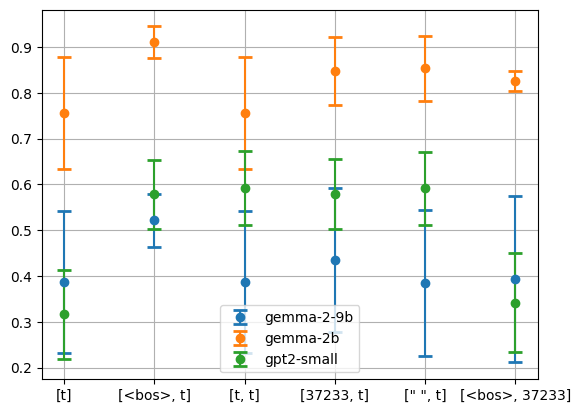

In [67]:


for i, (model_name, (layers, means, ranks, stds)) in enumerate(data.items()):
    mean_means = {k: torch.tensor(v).mean() for k, v in means.items()}
    mean_stds = {k: torch.tensor(v).std() for k, v in means.items()}

    plt.errorbar(list(mean_means.keys()), list(mean_means.values()), yerr=list(mean_stds.values()), fmt='o', capsize=5, capthick=2, label=model_name)

        

    plt.grid()

plt.legend()
f.supylabel('Mean Cosine Similarity')  # Overall Y-axis label

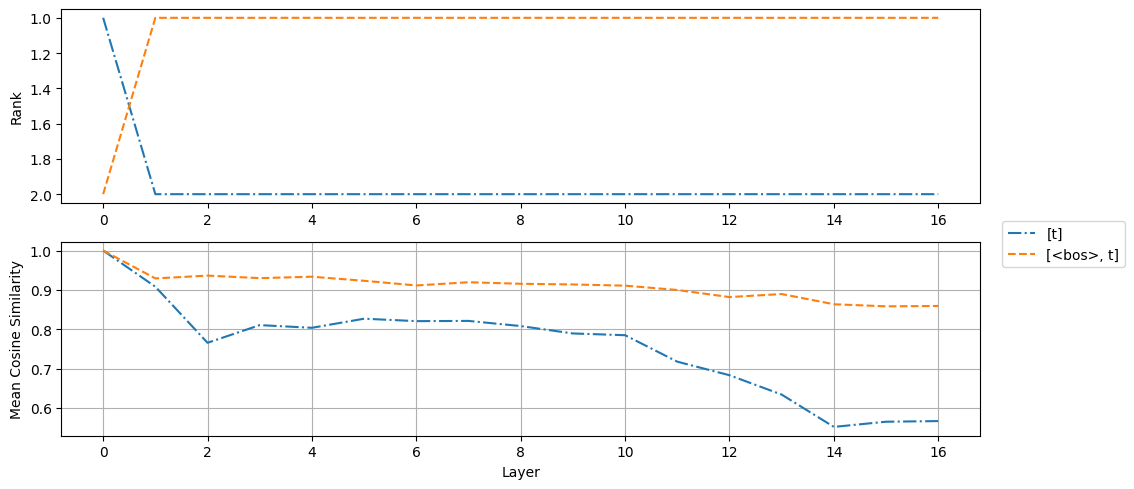

In [35]:
f, ax = plt.subplots(2, 1, figsize=(10, 5))

for k in ranks.keys():
    linestyle = '-'
    if k == '[<bos>, t]':
        linestyle = '--'
    elif k == '[t]':
        linestyle = '-.'
    
    ax[0].plot(layers, ranks[k], label=k, linestyle=linestyle)

# ax[0].gca().invert_yaxis()
# ax[0].set_xlabel('Layer')
ax[0].set_ylabel('Rank')
# ax[0].grid()

ax[0].invert_yaxis() 

for k in means.keys():
    linestyle = '-'
    if k == '[<bos>, t]':
        linestyle = '--'
    elif k == '[t]':
        linestyle = '-.'

    ax[1].plot(layers, means[k], linestyle=linestyle)


ax[1].grid()
ax[1].set_xlabel('Layer')
ax[1].set_ylabel('Mean Cosine Similarity')

f.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout() 


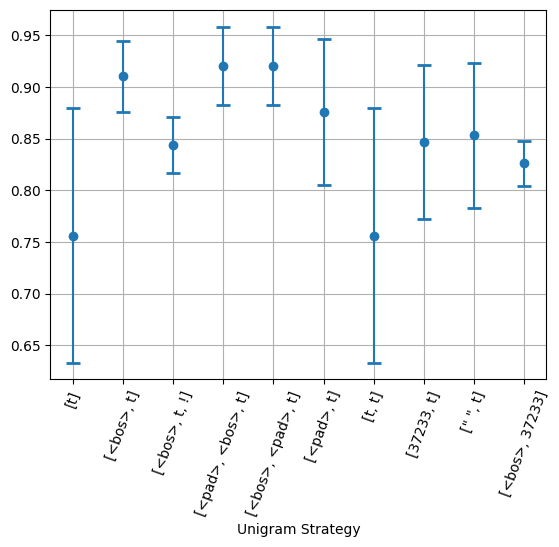

In [29]:
mean_means = {k: torch.tensor(v).mean() for k, v in means.items()}
mean_stds = {k: torch.tensor(v).std() for k, v in means.items()}

plt.errorbar(list(mean_means.keys()), list(mean_means.values()), yerr=list(mean_stds.values()), fmt='o', capsize=5, capthick=2, label=k)
plt.grid()
plt.xlabel('Unigram Strategy')
plt.xticks(rotation=70)
print()

raw torch.Size([20]) tensor(0.5752) tensor(0.1064)
bos torch.Size([20]) tensor(0.9008) tensor(0.0378)
2bos torch.Size([20]) tensor(0.8971) tensor(0.0388)
padbos torch.Size([20]) tensor(0.9015) tensor(0.0364)
bospad torch.Size([20]) tensor(0.8965) tensor(0.0325)
bosrepeat torch.Size([20]) tensor(0.8856) tensor(0.0360)
repeat torch.Size([20]) tensor(0.5752) tensor(0.1064)
repeat3 torch.Size([20]) tensor(0.5752) tensor(0.1064)
repeat6 torch.Size([20]) tensor(0.5752) tensor(0.1064)
space torch.Size([20]) tensor(0.7453) tensor(0.0616)
pad torch.Size([20]) tensor(0.7524) tensor(0.0594)
space2 torch.Size([20]) tensor(0.7542) tensor(0.0593)
rand torch.Size([20]) tensor(0.7243) tensor(0.0676)
controlbos torch.Size([20]) tensor(-0.1420) tensor(0.2691)
control torch.Size([20]) tensor(0.6213) tensor(0.1819)
controlbos1 torch.Size([20]) tensor(-0.1420) tensor(0.2691)
control1 torch.Size([20]) tensor(0.6213) tensor(0.1819)



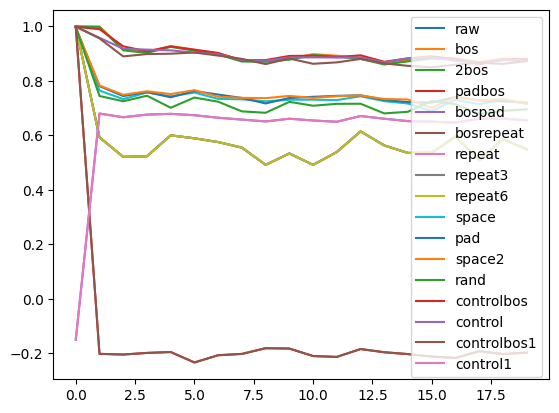

In [66]:
model_name = 'gemma-2b'
filename = f'../cruft/padmode_{model_name}_blocks.16.hook_resid_pre_corrs-1000.json'
with open(filename) as f:
    corrs = json.load(f)

for k, token_dict in corrs.items():
    s = torch.stack([torch.tensor(t) for t in token_dict]).mean(dim=0)[:20]
    print(k, s.shape, s.mean(), s.std())
    plt.plot(s, label=k)

plt.legend()
print()

raw torch.Size([20]) tensor(0.5817) tensor(0.1040)
bos torch.Size([20]) tensor(0.9096) tensor(0.0359)
padbos torch.Size([20]) tensor(0.9100) tensor(0.0357)
pad2bos torch.Size([20]) tensor(0.9092) tensor(0.0357)
bospad2 torch.Size([20]) tensor(0.9013) tensor(0.0334)
controlbos torch.Size([20]) tensor(-0.1406) tensor(0.2687)
control torch.Size([20]) tensor(0.6272) tensor(0.1833)
boscontrol torch.Size([20]) tensor(0.7887) tensor(0.2429)



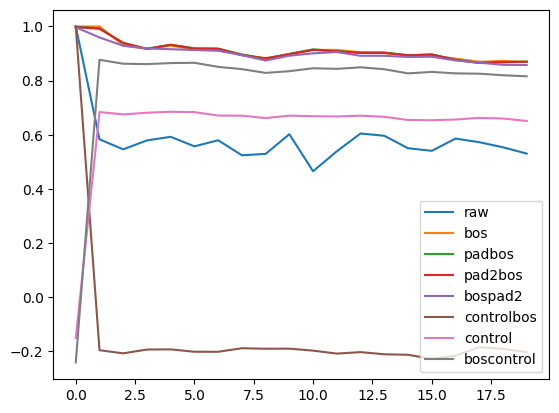

In [77]:
model_name = 'gemma-2b'
filename = f'../cruft/padmode_{model_name}_blocks.16.hook_resid_pre_corrs.json'
with open(filename) as f:
    corrs = json.load(f)

for k, token_dict in corrs.items():
    if k not in ['bos', 'raw', 'bosrepeat', 'padbos', 'control', 'controlbos', 'boscontrol', 'pad2bos', 'bospad2']:
        continue

    # if k != 'raw':
    #     continue
    
    s = torch.stack([torch.tensor(t) for t in token_dict]).mean(dim=0)[:20]
    print(k, s.shape, s.mean(), s.std())
    plt.plot(s, label=k)

plt.legend()
print()

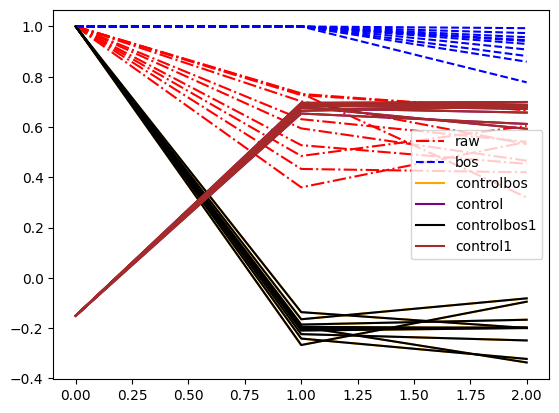

In [58]:
model_name = 'gemma-2b'
filename = f'../cruft/padmode_{model_name}_blocks.16.hook_resid_pre_corrs-1000.json'
with open(filename) as f:
    corrs = json.load(f)

colors = cycle(['red', 'blue', 'green', 'orange', 'purple', 'black', 'brown', 'pink', 'gray', 'cyan'])

for k, token_dict in corrs.items():
    color = next(colors)
    s = torch.stack([torch.tensor(t) for t in token_dict])

    for i in range(10):

        
        linestyle = '-'

        if k == 'bos':
            linestyle = '--'
        elif k == 'raw':
            linestyle = '-.'

        if i == 0:
            label = k
        else:
            label = None

        if k not in ['bos', 'raw', 'control', 'controlbos', 'control1', 'controlbos1']: 
            continue
        plt.plot(s[i, :3], color=color, linestyle=linestyle, label=label)

plt.legend()
print()